# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1<br><br>
<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
    
</center>


In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df.query("group=='treatment' & landing_page != 'new_page'").shape[0]

1965

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page')) ] 

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id.. 
df2.drop(df2[df2.index==1899].index,axis=0,inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id']==773192]

C:\Users\Mohamed\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  


**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

$p_{population}$.



In [15]:
p_converted = df2.converted.mean()
p_converted

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_control_converted = df2.query("group=='control' & converted == 1").shape[0] / df2.query("group=='control'").shape[0]
p_control_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_treatment_converted=df2.query("group=='treatment' & converted == 1").shape[0] / df2.query("group=='treatment'").shape[0]
p_treatment_converted

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment_converted-p_control_converted
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
p_new_page = df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]
p_new_page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

**The conversion rate in the control group is slightly higher than the treatment group  but the diffrence is very small. 
we can say that the new treatment group did not lead to a greater conversion rate**

<a id='ab_test'></a>
## Part II - A/B Test


### ToDo 2.1



**$H_0$**: **$p_{old}$** >= **$p_{new}$**
<br>
**$H_1$**: **$p_{new}$** >**$p_{old}$**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
p_new_undernull = df2.converted.mean()
p_new_undernull

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
p_old_undernull = p_new_undernull
p_old_undernull

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [22]:
n_new = df2.query("group=='treatment'").shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query("group=='control'").shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(df2['converted'],n_new,p_new_undernull)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis.

In [25]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(df2['converted'],n_old,p_old_undernull) 

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0008209962569104834


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 


In [27]:
# Sampling distribution 
p_diffs = []
new_page_converted =  np.random.binomial(n_new, p_new_undernull, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old_undernull, 10000)/n_old
p_diffs.append(new_page_converted - old_page_converted)

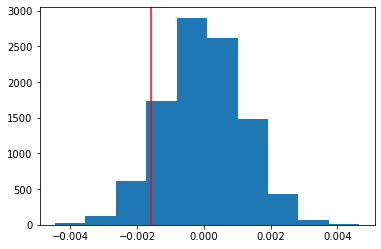

In [28]:
plt.hist(p_diffs)
plt.axvline(obs_diff,color='red')
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
p_diffs= np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9062

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  <br><br>
 <br>
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

** - What is this value called in scientific studies?  <br><br>
>: P_Value . <br> 
>In null hypothesis significance testing, the p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.
 <br>
 <br>
 <br>
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? <br><br>
>The P_value is greater than the Type 1 erorr rate (0.05) which means there is no enough evidence to reject the null Hypothesis. 
**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old =  df2.query("landing_page == 'old_page'")['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'").shape[0]

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [31]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]),alternative ='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>**Answer.** :<br>
The z-score value indicates that the  difference between our test statistic and the null hypothesis is 1.31 standard deviations below the mean.which is lower than the critical value 1.6456 for one-tailed tests that we would need to reject the null hypothesis. 
The P-value is .905 which is greater than the value of alpha .05 which means we don't have enough evidence to reject the null hypothesis.


<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [32]:
df2['intercept']=1
df2[['dummy','ab_page']] = pd.get_dummies(df2['group']) 
#df2['ab_page']=ab_page
df2.head()

<ipython-input-32-bdf9d28b8bf7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept']=1
C:\Users\Mohamed\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,dummy,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [33]:
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Nov 2021   Pseudo R-squ.:               8.077e-06
Time:                        17:13:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

>The logistic regression model null and alternative hypotheses are

>**$H_0$**: **$p_{old}$** = **$p_{new}$**
<br>
>**$H_1$**: **$p_{new}$** !=**$p_{old}$**

<br>

>The P-value associated with ab_Page is 0.190 and it differs from the value found in Part ||  because in part || we made a one-sided test and the logistic regression model does two-sided test.
<br>

>The current p-value for the logistic regression model is greater than alpha which states that there is no enough evidence to  reject he null hypothesis.


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


>Adding other factors can be benificial to our analysis results and could lead to mroe accurate decisions , one of disadvantges is that some relelationships can appear in , one of the main disadvantges that the model gets more complex 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 


2. Does it appear that country had an impact on conversion? . 


In [35]:
# Read the countries.csv
countries = pd.read_csv("countries.csv")

In [36]:
# Join with the df2 dataframe
df3 = df2.merge(countries,on='user_id')

In [37]:
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [38]:
# Create the necessary dummy variables
df3[['ca','uk','us']]=pd.get_dummies(df3['country'])
df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,dummy,ab_page,country,ca,uk,us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0


**h. Fit your model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.
 


In [39]:
# Fit your model, and summarize the results
model = sm.Logit(df3['converted'],df3[['intercept','ab_page','ca','us']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 07 Nov 2021   Pseudo R-squ.:               2.323e-05
Time:                        17:13:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
ca            -0.0506      0.028     -1.784      0.074      -0.106       0.005
us            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

>**We can assume that there is no significant effect on the convertion based on the country both p-values are greater than .05.**

Now we will see if the interaction between country and page will cause a significant effects on conversion

In [40]:
df3['us_ab'] = df3['us'] *df3['ab_page']
df3['ca_ab'] = df3['ca'] *df3['ab_page']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,dummy,ab_page,country,ca,uk,us,us_ab,ca_ab
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [41]:
lm = sm.Logit(df3['converted'],df3[['intercept','ab_page','us','us_ab','ca','ca_ab']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Nov 2021   Pseudo R-squ.:               3.482e-05
Time:                        17:13:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
us             0.0057      0.019      0.306      0.760      -0.031       0.043
us_ab         -0.0314      0.027     -1.181      0.238      -0.084       0.021
ca            -0.0118      0.040     -0.296      0.767      -0.090       0.066
ca_ab         -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

*** We can see that in both interaction the resulting P-value is greater than the alpha .05 which indicates that there is no significant effects on influence of the landing page in diffrent countries ***

**Conclusion** 

>There in no enough evidence to prove that the new page really increases the conversion rate compared to the old page.
we results we got from the probability and the A/B hypothesis test and even the regression model all indicates that there is no enough evidence to reject the null hypothesis.
The Result indicates that the new page has no significant impact on the conversion rate.

**Result** <br>
>We can say that the best option is to keep the old page or create a new page model.